In [29]:
%load_ext autoreload
%autoreload 2
import RNA
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import calc_MCC, dict_dot_bracket, list_dot_bracket, forna_display, parse_rdat
from penalties import penalize_barriers, get_penalties, penalize_barriers_seq, pairing_frequency, penalize_barriers_ensemble

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
shape_data = {}
rdat_files = sorted(['SRP_test/'+f for f in os.listdir('SRP_test') if 'rdat' in f])
#rdat_files = ['SRP_test/'+'SRPECLI_BZCN_0001.rdat.txt']
for r in rdat_files:
    shape_data[r.strip('SRP_test/SRPECLI_').strip('.rdat.txt')] = parse_rdat(r)

# Create dummy data with no constraints
shape_data['kinetic20'] = {}
shape_data['no_constraints'] = {}
for l in shape_data['BZCN_0001']:
    shape_data['kinetic20'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
    shape_data['no_constraints'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
#d = parse_rdat('SRP_test/SRPECLI_BZCN_0001.rdat.txt')
md = RNA.md()
md.temperature = 37 #Both transcription and modification was done at 37

In [3]:
# Calculate folding pathways for each dataset
last_structure = ''
for n, d in shape_data.items():
    print(f'Working on {n}')
    for length in d.keys():
        subseq = d[length]['seq']
        reactivities = d[length]['react']
        # Shape-defined fold
        fc = RNA.fold_compound(subseq, md)
        if n not in ['no_constraints', 'kinetic20']:
            #fc.sc_add_SHAPE_deigan(reactivities, 2.6, -0.8)
            fc.sc_add_SHAPE_zarringhalam(reactivities, 0.8, 0.5, 'M')
        if n == 'kinetic20':
            step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : 20
            }
            fc.sc_add_f(penalize_barriers)
            fc.sc_add_data(step_info)
        d[length]['mfe'] = fc.mfe()[0]
        last_structure = d[length]['mfe']


Working on BZCN_0001
Working on BZCN_0002
Working on BZCN_0003
Working on BZCN_0004
Working on DMS_0001
Working on DMS_0002
Working on DMS_0003
Working on kinetic20
Working on no_constraints


In [4]:
# also try drtransformer
print("Working on drtransformer")
shape_data['drtransformer'] = {}
name = 'SRP_drt'
#subprocess.run(['cat', 'SRP_test/SRP.fa', '|', 'DrTransformer' '--name', f'{name}', '--logfile'], shell=True, check=True) # this doesn't work for some reason

with open(f'SRP_test/{name}.log', 'r') as f:
    lines = f.readlines()

last_len = 0
start_len = min(list(shape_data['BZCN_0001'].keys()))
for l in lines:
    l = l.strip()
    if '#' in l:
        continue
    l = l.split()
    curr_len = int(l[0])
    if curr_len < start_len:
        continue
    if curr_len == last_len: # The MFE structure for each length if the first line with that length
        continue
    shape_data['drtransformer'][curr_len] = {
        'seq' : shape_data['BZCN_0001'][curr_len]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][curr_len]['seq']))],
        'mfe' : l[2]
    }
    last_len = curr_len

Working on drtransformer


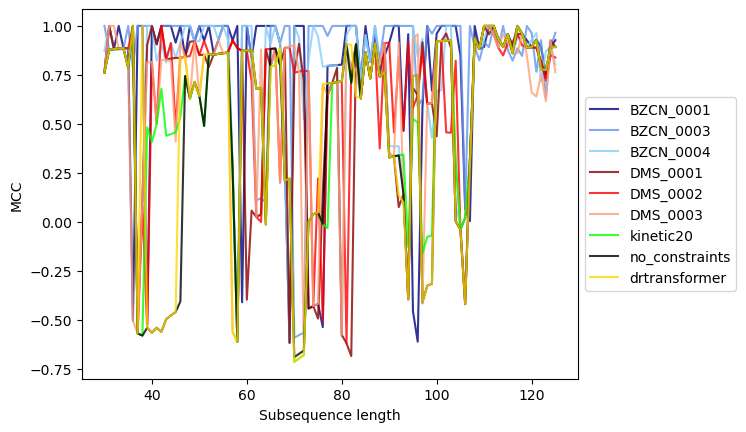

In [5]:
# Plot MCC at each length vs the no_constraints folding
# This at least tells us if if the kinetic method sees the same edges as the SHAPE data predicts
cols = {'BZCN_0001' : 'navy', 
        'BZCN_0002' : 'royalblue', 
        'BZCN_0003' : 'cornflowerblue', 
        'BZCN_0004' : 'lightskyblue', 
        'DMS_0001' : 'darkred', 
        'DMS_0002' : 'red', 
        'DMS_0003' : 'lightsalmon', 
        'kinetic20' : 'lime', 
        'drtransformer' : 'gold',
        'no_constraints' : 'black'}

fig, ax = plt.subplots()
#for n, d in [it for it in list(shape_data.items()) if it[0] != 'no_constraints']:
for n, d in [it for it in list(shape_data.items()) if it[0] != 'BZCN_0002']: #0002 is the most similar to the other BZCNs
    x = list(d.keys()) # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data['BZCN_0002'][l]['mfe'])) for l in list(d.keys())]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

ax.set_xlabel('Subsequence length')
ax.set_ylabel('MCC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

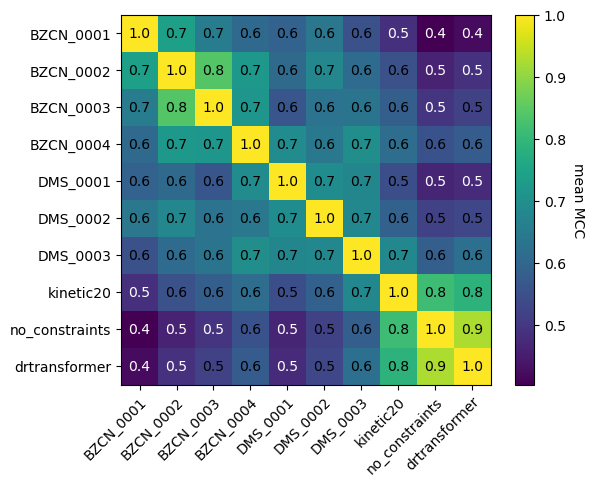

In [6]:
# plot mean MCC between different methods
fig, ax = plt.subplots()
corr = np.ones((len(shape_data.keys()), len(shape_data.keys())))
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(shape_data.items()):
        if i <= j:
            continue
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in list(d1.keys())])
        corr[i, j] = c
        corr[j, i] = c

im = ax.imshow(corr, origin='upper')
ax.set_yticks(np.arange(len(shape_data.keys())), list(shape_data.keys()))
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(corr.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(corr)):
    for j in range(len(corr)):
        kw.update(color=textcolors[int(corr[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(corr[i,j]), **kw)

plt.show()

In [7]:
# Let's try a single-value penalty sweep.  This isn't going to work, but its useful to see.

penalties = np.arange(5, 105, 5)
pred_at_pen = {}
for p in penalties:
    print("working on penalty =", p)
    pred_at_pen[p] = {}
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : int(p)
            }
        fc.sc_add_f(penalize_barriers)
        fc.sc_add_data(step_info)

        pred_at_pen[p][length] = fc.mfe()[0]
        last_structure = pred_at_pen[p][length]

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [8]:
penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_pen[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_pen[20].keys())])

In [9]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5	0.557	0.740	0.626
10	0.549	0.737	0.619
15	0.549	0.737	0.619
20	0.557	0.757	0.632
25	0.548	0.732	0.617
30	0.491	0.676	0.560
35	0.476	0.650	0.542
40	0.476	0.650	0.542
45	0.476	0.650	0.542
50	0.468	0.642	0.533
55	0.457	0.630	0.522
60	0.429	0.570	0.482
65	0.530	0.646	0.574
70	0.523	0.641	0.567
75	0.515	0.632	0.559
80	0.478	0.591	0.521
85	0.478	0.591	0.521
90	0.470	0.582	0.512
95	0.470	0.582	0.512
100	0.452	0.564	0.494

Best!
bzcn:	penalty=20 MCC=0.557
dms:	penalty=20 MCC=0.757
all:	penalty=20 MCC=0.632


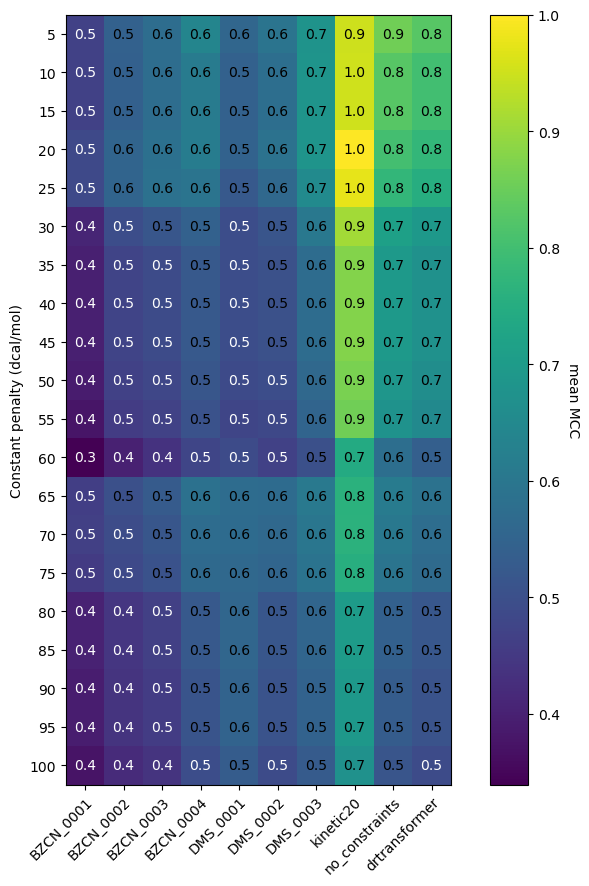

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(penalty_sweep[i, j]), **kw)

plt.show()

In [11]:
# Let's try the situation where it's dependent on the base pair broken

percents = np.arange(0.01, 0.262, 0.012)
pred_at_cent = {}
for p in percents:
    print("Working on percentage = {:.3f}".format(p), end='; ')
    pred_at_cent[p] = {}
    p_list = []
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        if last_structure != '':
            fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
            penalty_dict = get_penalties(last_structure, fc_last)
            p_list.extend([v for v in penalty_dict.values()])
        else:
            penalty_dict = {}
        step_info = {
            'last_dict' : dict_dot_bracket(last_structure),
            'penalty_dict' : penalty_dict,
            'penalty_percent' : p
            }
        fc.sc_add_f(penalize_barriers_seq)
        fc.sc_add_data(step_info)

        pred_at_cent[p][length] = fc.mfe()[0]
        last_structure = pred_at_cent[p][length]
    
    print("mean penalty = {:.0f}".format(np.mean(p_list)*p))

Working on percentage = 0.010; mean penalty = 4
Working on percentage = 0.022; mean penalty = 9
Working on percentage = 0.034; mean penalty = 14
Working on percentage = 0.046; mean penalty = 19
Working on percentage = 0.058; mean penalty = 24
Working on percentage = 0.070; mean penalty = 29
Working on percentage = 0.082; mean penalty = 34
Working on percentage = 0.094; mean penalty = 39
Working on percentage = 0.106; mean penalty = 44
Working on percentage = 0.118; mean penalty = 49
Working on percentage = 0.130; mean penalty = 54
Working on percentage = 0.142; mean penalty = 59
Working on percentage = 0.154; mean penalty = 64
Working on percentage = 0.166; mean penalty = 69
Working on percentage = 0.178; mean penalty = 74
Working on percentage = 0.190; mean penalty = 79
Working on percentage = 0.202; mean penalty = 84
Working on percentage = 0.214; mean penalty = 89
Working on percentage = 0.226; mean penalty = 94
Working on percentage = 0.238; mean penalty = 99
Working on percentage 

In [12]:
cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_cent[0.01].keys())])

In [13]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.557	0.740	0.626
0.022	0.556	0.747	0.627
0.034	0.566	0.760	0.639
0.046	0.566	0.760	0.639
0.058	0.557	0.757	0.632
0.070	0.548	0.732	0.617
0.082	0.542	0.731	0.613
0.094	0.477	0.651	0.542
0.106	0.477	0.651	0.542
0.118	0.468	0.642	0.534
0.130	0.468	0.642	0.534
0.142	0.468	0.642	0.534
0.154	0.429	0.570	0.482
0.166	0.530	0.646	0.574
0.178	0.524	0.643	0.569
0.190	0.516	0.634	0.560
0.202	0.484	0.598	0.527
0.214	0.484	0.598	0.527
0.226	0.484	0.598	0.527
0.238	0.484	0.598	0.527
0.250	0.476	0.589	0.518

Best!
bzcn:	penalty=0.034 MCC=0.566
dms:	penalty=0.034 MCC=0.760
all:	penalty=0.034 MCC=0.639


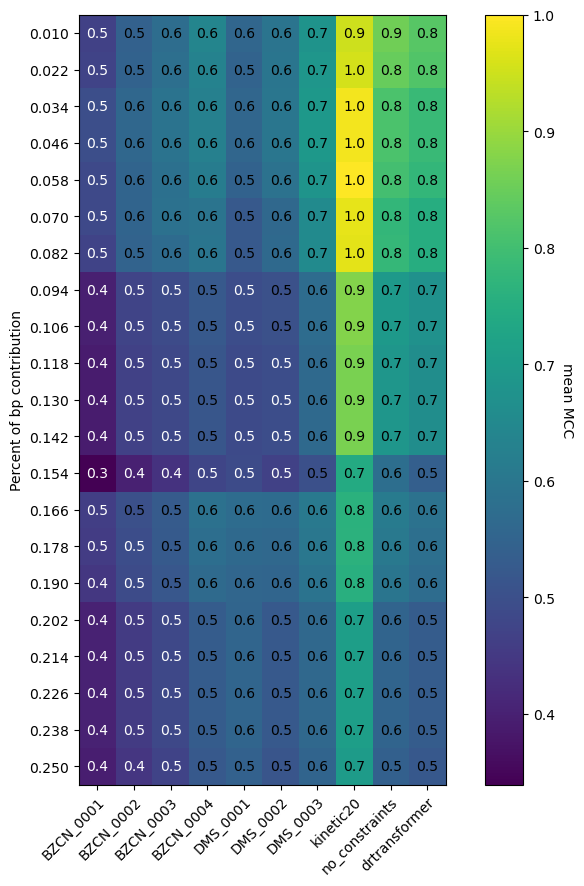

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(cent_sweep[i, j]), **kw)

plt.show()

In [15]:
#p = .5
#last_structure = ''
#for length in shape_data['kinetic20'].keys():
#    subseq = shape_data['kinetic20'][length]['seq']
#    fc = RNA.fold_compound(subseq, md)
#    fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
#    penalty_dict = get_penalties(last_structure, fc_last)
#    step_info = {
#            'last_dict' : dict_dot_bracket(last_structure),
#            'penalty_dict' : penalty_dict,
#            'penalty_percent' : p
#        }
#    fc.sc_add_f(penalize_barriers_seq)
#    fc.sc_add_data(step_info)
#
#    out = fc.mfe()
#
#    last_structure = out[0]
#    print(out)

In [16]:
# Let's see how this compares with hierarchical folding
# The problem here is that I have even less of a 'ground truth' in this case
pred_at_span_pen = {}
full_seq = shape_data['kinetic20'][list(shape_data['kinetic20'].keys())[-1]]['seq']

for p in penalties:
    print("working on penalty =", p)
    pred_at_span_pen[p] = {}
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        mds = RNA.md()
        mds.temperature = 37
        mds.max_bp_span = length
        step_info = {
            'last' : dict_dot_bracket(last_structure),
            'penalty' : int(p)
        }
        fc = RNA.fold_compound(full_seq, mds)
        fc.sc_add_f(penalize_barriers)
        fc.sc_add_data(step_info)
        pred_at_span_pen[p][length] = fc.mfe()[0]
        last_structure = pred_at_span_pen[p][length]


working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [17]:
span_penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        span_penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_span_pen[p][l])[:l], list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_span_pen[5].keys())])

In [18]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(span_penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.337	0.455	0.381
0.022	0.338	0.457	0.383
0.034	0.338	0.457	0.383
0.046	0.238	0.383	0.292
0.058	0.262	0.383	0.308
0.070	0.262	0.383	0.308
0.082	0.262	0.382	0.307
0.094	0.268	0.394	0.315
0.106	0.268	0.394	0.315
0.118	0.268	0.394	0.315
0.130	0.260	0.368	0.300
0.142	0.226	0.333	0.266
0.154	0.081	0.183	0.119
0.166	0.081	0.183	0.119
0.178	0.081	0.183	0.119
0.190	0.081	0.183	0.119
0.202	-0.045	0.057	-0.007
0.214	-0.045	0.057	-0.007
0.226	-0.045	0.057	-0.007
0.238	-0.045	0.057	-0.007

Best!
bzcn:	penalty=0.022 MCC=0.338
dms:	penalty=0.022 MCC=0.457
all:	penalty=0.022 MCC=0.383


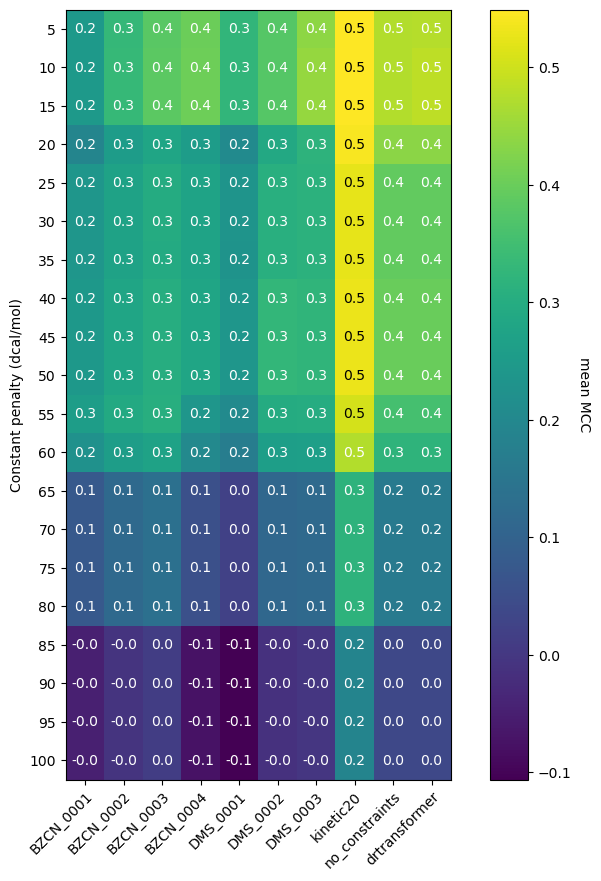

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(span_penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(span_penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(span_penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(span_penalty_sweep[i, j]), **kw)

In [20]:
# And finally, let's try penalties based on ensemble folding of the structure.
pred_at_ens_pen = {}

for p in penalties:
    print("working on penalty =", p)
    pred_at_ens_pen[p] = {}
    last_ensemble = []
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        if last_ensemble != []:
            last_freqs = pairing_frequency(last_ensemble)
        else:
            last_freqs = np.zeros(len(subseq))

        freqs = np.zeros((len(subseq), len(subseq)))
        freqs[:len(last_freqs), :len(last_freqs)] = last_freqs
        
        step_info = {
            'freqs' : freqs,
            'penalty' : int(p)
        }
        fc = RNA.fold_compound(subseq, mds)
        fc.sc_add_f(penalize_barriers_ensemble)
        fc.sc_add_data(step_info)
        competing = fc.subopt(500)
        last_ensemble = competing
        pred_at_ens_pen[p][length] = last_ensemble[0].structure

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [21]:
ens_penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        ens_penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_ens_pen[p][l])[:l], list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_ens_pen[5].keys())])

In [22]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(ens_penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5.000	0.465	0.634	0.528
10.000	0.535	0.713	0.602
15.000	0.541	0.727	0.611
20.000	0.539	0.717	0.606
25.000	0.510	0.686	0.576
30.000	0.509	0.694	0.578
35.000	0.502	0.677	0.568
40.000	0.509	0.685	0.575
45.000	0.508	0.690	0.577
50.000	0.508	0.690	0.576
55.000	0.511	0.688	0.577
60.000	0.502	0.678	0.568
65.000	0.478	0.651	0.543
70.000	0.463	0.633	0.526
75.000	0.452	0.621	0.515
80.000	0.430	0.589	0.490
85.000	0.419	0.573	0.477
90.000	0.403	0.554	0.460
95.000	0.405	0.551	0.460
100.000	0.407	0.548	0.460

Best!
bzcn:	penalty=15.000 MCC=0.541
dms:	penalty=15.000 MCC=0.727
all:	penalty=15.000 MCC=0.611


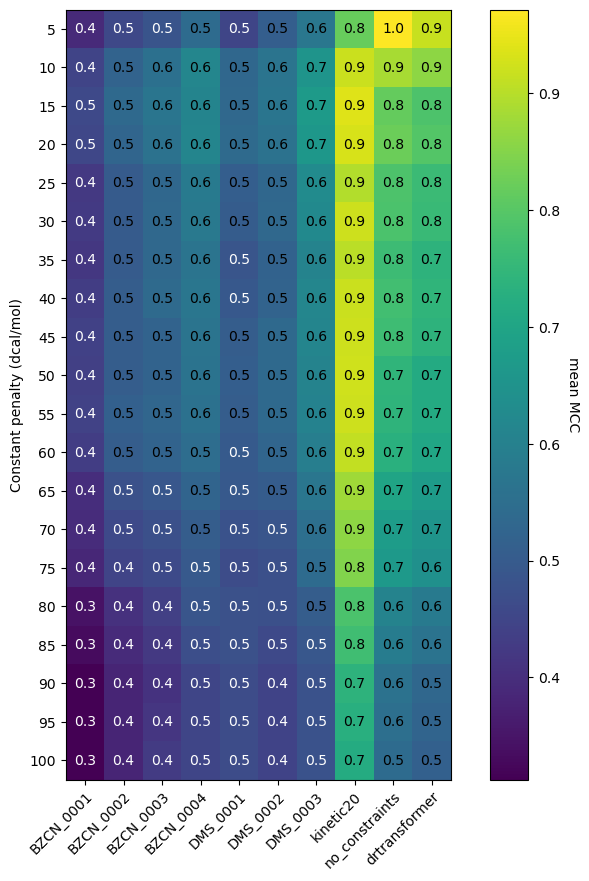

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ens_penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(ens_penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(ens_penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(ens_penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(ens_penalty_sweep[i, j]), **kw)

In [24]:
mfe_percent = []
e_range = np.arange(50, 1050, 50)
for e in e_range:
    e = int(e)
    fc = RNA.fold_compound(full_seq, md)
    competing = fc.subopt(e)
    energies = np.array([c.energy for c in competing])
    energies *= -1 * 1.624
    mfe_percent.append(np.exp(energies[0]) / np.sum(np.exp(energies)))


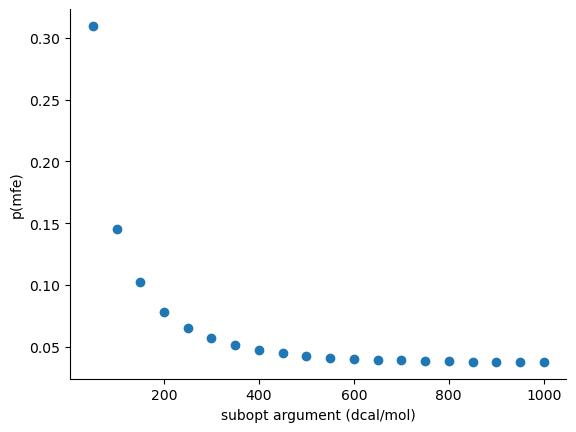

In [25]:
fig, ax = plt.subplots()
ax.scatter(e_range, mfe_percent)
ax.set_ylabel('p(mfe)')
ax.set_xlabel('subopt argument (dcal/mol)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

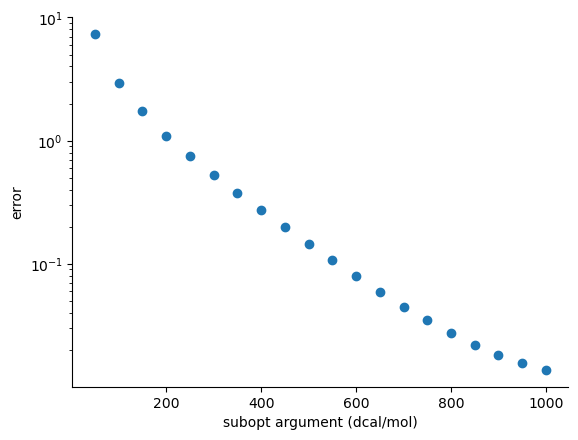

In [26]:
real = 0.0370808

error = [(m - real)/real for m in mfe_percent]
fig, ax = plt.subplots()
ax.scatter(e_range, error)
ax.set_ylabel('error')
ax.set_yscale('log')
ax.set_xlabel('subopt argument (dcal/mol)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [36]:
# And finally, let's try penalties based on ensemble folding of the structure.
pred_at_ens_cent = {}

tmp_percents = [0.1]
for p in tmp_percents:
    print("Working on percentage = {:.3f}".format(p), end='; ')
    pred_at_ens_cent[p] = {}
    last_ensemble = []
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        print(length)
        if last_ensemble != []:
            print(subseq[:len(last_ensemble[0].structure)])
            fc_last = RNA.fold_compound(subseq[:len(last_ensemble[0].structure)], md)
            last_freqs = pairing_frequency(last_ensemble, fc_last)
            print(last_freqs[15])
            
        else:
            last_freqs = np.zeros(len(subseq))

        freqs = np.zeros((len(subseq), len(subseq)))
        freqs[:len(last_freqs), :len(last_freqs)] = last_freqs
        
        step_info = {
            'freqs' : freqs,
            'penalty' : int(p)
        }
        fc = RNA.fold_compound(subseq, mds)
        fc.sc_add_f(penalize_barriers_ensemble)
        fc.sc_add_data(step_info)
        competing = fc.subopt(500)
        last_ensemble = competing
        pred_at_ens_cent[p][length] = last_ensemble[0].structure

Working on percentage = 0.100; 30
31
AUCGGGGGCUCUGUUGGUUCUCCCGCAACG
..((((((..((...))..)))))).....
{16: 12, 12: 16, 17: 11, 11: 17, 20: 8, 8: 20, 21: 7, 7: 21, 22: 6, 6: 22, 23: 5, 5: 23, 24: 4, 4: 24, 25: 3, 3: 25}
..((((((.((....))..)))))).....
{16: 11, 11: 16, 17: 10, 10: 17, 20: 8, 8: 20, 21: 7, 7: 21, 22: 6, 6: 22, 23: 5, 5: 23, 24: 4, 4: 24, 25: 3, 3: 25}
..((((((..(.....)..)))))).....
{17: 11, 11: 17, 20: 8, 8: 20, 21: 7, 7: 21, 22: 6, 6: 22, 23: 5, 5: 23, 24: 4, 4: 24, 25: 3, 3: 25}
...(((((..((...))..)))))......
{16: 12, 12: 16, 17: 11, 11: 17, 20: 8, 8: 20, 21: 7, 7: 21, 22: 6, 6: 22, 23: 5, 5: 23, 24: 4, 4: 24}
.(((((((..((...))..)))))).)...
{16: 12, 12: 16, 17: 11, 11: 17, 20: 8, 8: 20, 21: 7, 7: 21, 22: 6, 6: 22, 23: 5, 5: 23, 24: 4, 4: 24, 25: 3, 3: 25, 27: 2, 2: 27}
..((((((..(....)...)))))).....
{16: 11, 11: 16, 20: 8, 8: 20, 21: 7, 7: 21, 22: 6, 6: 22, 23: 5, 5: 23, 24: 4, 4: 24, 25: 3, 3: 25}
..((((((...........)))))).....
{20: 8, 8: 20, 21: 7, 7: 21, 22: 6, 6: 22, 23

KeyboardInterrupt: 

In [ ]:
ens_cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        ens_cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_ens_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_ens_cent[0.01].keys())])

In [ ]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(ens_cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ens_cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(ens_cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(ens_cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(ens_cent_sweep[i, j]), **kw)